<a href="https://colab.research.google.com/github/Asthy247/Snowflake_Churn_Prediction_Project.ipynb/blob/main/Churn_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snowflake-connector-python pandas scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 5.9 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata

In [ ]:
from google.colab import userdata

# These lines will trigger pop-up boxes for you to enter your credentials
# when you run this cell.
SNOWFLAKE_ACCOUNT = userdata.get('SNOWFLAKE_ACCOUNT') # Enter your account identifier here (e.g., 'xyz12345.us-east-1')
SNOWFLAKE_USER = userdata.get('SNOWFLAKE_USER')       # Enter your Snowflake username here
SNOWFLAKE_PASSWORD = userdata.get('SNOWFLAKE_PASSWORD') # Enter your Snowflake password here

In [ ]:
import snowflake.connector
import pandas as pd

# --- Snowflake Connection Configuration ---
# These variables will get their values from the secure userdata prompts
# They are already loaded from the previous cell.
# SNOWFLAKE_ACCOUNT = userdata.get('SNOWFLAKE_ACCOUNT')
# SNOWFLAKE_USER = userdata.get('SNOWFLAKE_USER')
# SNOWFLAKE_PASSWORD = userdata.get('SNOWFLAKE_PASSWORD')

# Other details can be hardcoded as they are not sensitive
SNOWFLAKE_WAREHOUSE = 'COMPUTE_WH' # Or your specific warehouse name
SNOWFLAKE_DATABASE = 'CHURN_PREDICTION_DW'
SNOWFLAKE_SCHEMA = 'FEATURES' # We'll pull features from here

# --- Establish Connection to Snowflake ---
try:
    conn = snowflake.connector.connect(
        user=SNOWFLAKE_USER,
        password=SNOWFLAKE_PASSWORD,
        account=SNOWFLAKE_ACCOUNT,
        warehouse=SNOWFLAKE_WAREHOUSE,
        database=SNOWFLAKE_DATABASE,
        schema=SNOWFLAKE_SCHEMA
    )
    cursor = conn.cursor()
    print("Successfully connected to Snowflake!")

    # --- Fetch Data from Snowflake ---
    query = "SELECT * FROM FEATURES.CUSTOMER_CHURN_FEATURES"
    cursor.execute(query)
    df = cursor.fetch_pandas_all()

    print(f"Successfully fetched {len(df)} rows from Snowflake.")
    print("DataFrame head:")
    print(df.head())

except snowflake.connector.errors.ProgrammingError as e:
    print(f"Snowflake Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
finally:
    if 'conn' in locals() and conn:
        cursor.close()
        conn.close()
        print("\nSnowflake connection closed.")

Successfully connected to Snowflake!
Successfully fetched 10 rows from Snowflake.
DataFrame head:
  CUSTOMER_ID  TENURE_MONTHS  MONTHLY_CHARGES  TOTAL_CHARGES  \
0        C001             24             50.0         1200.0   
1        C002              1             70.0           70.0   
2        C003             12             95.0         1140.0   
3        C004             60             20.0         1200.0   
4        C005              8             60.0          480.0   

   AVG_CHARGE_PER_MONTH  IS_SENIOR_CITIZEN  HAS_PARTNER  HAS_DEPENDENTS  \
0                  50.0              False         True           False   
1                  70.0              False        False           False   
2                  95.0               True        False           False   
3                  20.0              False         True            True   
4                  60.0              False        False           False   

   HAS_PHONE_SERVICE  HAS_MULTIPLE_LINES  ...  INTERNET_SERVICE_NO


Training data shape: (8, 28)
Testing data shape: (2, 28)

Logistic Regression model trained successfully.

--- Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         1
        True       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


Confusion Matrix:
[[1 0]
 [0 1]]

ROC AUC Score: 1.0000

--- Feature Importance (Coefficients) ---
                            Feature  Coefficient
1                   MONTHLY_CHARGES     0.179482
3              AVG_CHARGE_PER_MONTH     0.179482
26  PAYMENT_METHOD_ELECTRONIC_CHECK     0.007046
18             INTERNET_SERVICE_DSL     0.007029
11            HAS_DEVICE_PROTECTION     0.006750
16                    GENDER_FEMALE     0.005545
15             IS_PAPERLESS_BILLING     0.004969
21     CONTRACT_TYPE_MONT

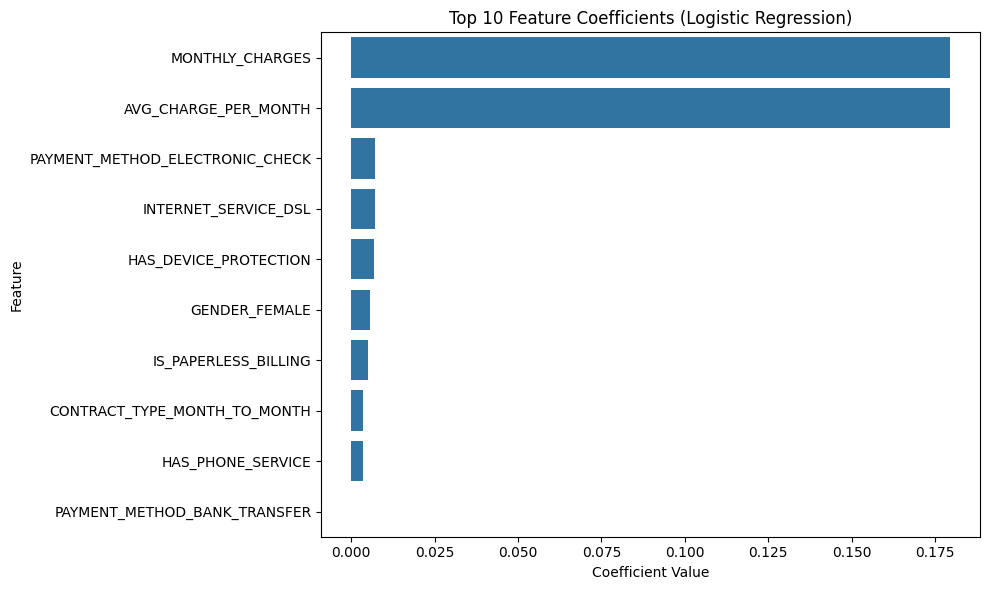

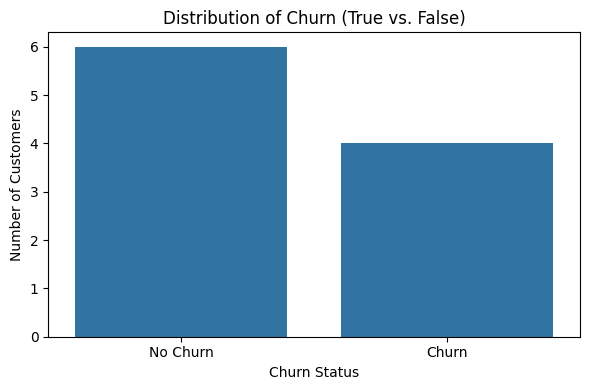

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare Data for Machine Learning ---
# Define features (X) and target (y)
# Drop CUSTOMER_ID as it's not a feature for the model
# Ensure all feature columns are numerical (booleans are treated as 0/1 by scikit-learn)
X = df.drop(['CUSTOMER_ID', 'CHURN_LABEL', 'FEATURE_LOAD_TIMESTAMP'], axis=1)
y = df['CHURN_LABEL']

# Handle potential non-numeric columns if any slipped through (e.g., if you had object types)
# This step is mostly for robustness, as our SQL feature engineering should have handled it.
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"Warning: Column '{col}' is still object type. Converting to numeric.")
        # For demonstration, we'll try to convert to numeric, coercing errors
        X[col] = pd.to_numeric(X[col], errors='coerce')
        X[col] = X[col].fillna(X[col].mean()) # Simple imputation for any NaNs from coercion

# Split data into training and testing sets
# stratify=y ensures that the proportion of churned/non-churned customers is similar in train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# --- Train a Machine Learning Model (Logistic Regression) ---
# Using Logistic Regression as a simple, interpretable baseline model
model = LogisticRegression(random_state=42, solver='liblinear') # liblinear is good for small datasets
model.fit(X_train, y_train)
print("\nLogistic Regression model trained successfully.")

# --- Evaluate the Model ---
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] # Probability of positive class (churn)

print("\n--- Model Evaluation ---")
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# --- Feature Importance (for Logistic Regression, coefficients indicate importance) ---
# Coefficients show the impact of each feature on the log-odds of churn
print("\n--- Feature Importance (Coefficients) ---")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(feature_importance)

# --- Data Visualization (Example 1: Feature Importance Bar Plot) ---
# Visualizing the most impactful features for churn prediction
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(10)) # Top 10 features by coefficient
plt.title('Top 10 Feature Coefficients (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show() # Displays plot in Colab

# --- Data Visualization (Example 2: Churn Distribution from original data) ---
# Understanding the class balance of your target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='CHURN_LABEL', data=df)
plt.title('Distribution of Churn (True vs. False)')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.xticks(ticks=[0, 1], labels=['No Churn', 'Churn']) # Relabeling for clarity
plt.tight_layout()
plt.show() # Displays plot in Colab

Successfully connected to Snowflake!
Successfully fetched 10 rows from Snowflake.
DataFrame head:
  CUSTOMER_ID  TENURE_MONTHS  MONTHLY_CHARGES  TOTAL_CHARGES  \
0        C001             24             50.0         1200.0   
1        C002              1             70.0           70.0   
2        C003             12             95.0         1140.0   
3        C004             60             20.0         1200.0   
4        C005              8             60.0          480.0   

   AVG_CHARGE_PER_MONTH  IS_SENIOR_CITIZEN  HAS_PARTNER  HAS_DEPENDENTS  \
0                  50.0              False         True           False   
1                  70.0              False        False           False   
2                  95.0               True        False           False   
3                  20.0              False         True            True   
4                  60.0              False        False           False   

   HAS_PHONE_SERVICE  HAS_MULTIPLE_LINES  ...  INTERNET_SERVICE_NO

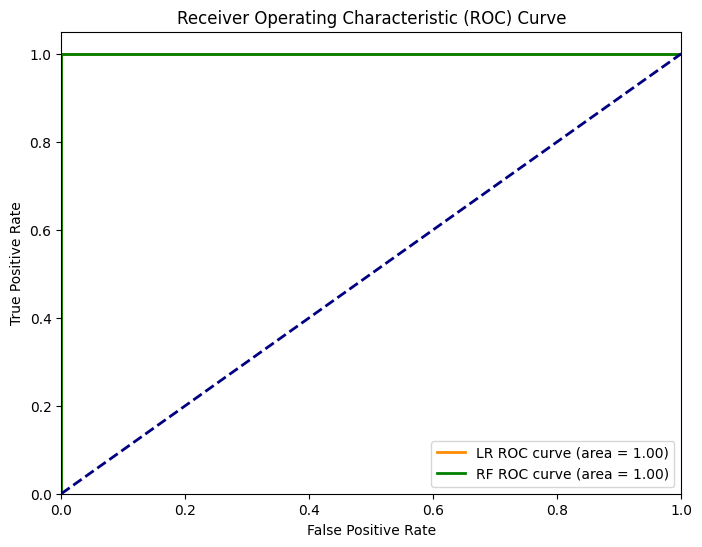

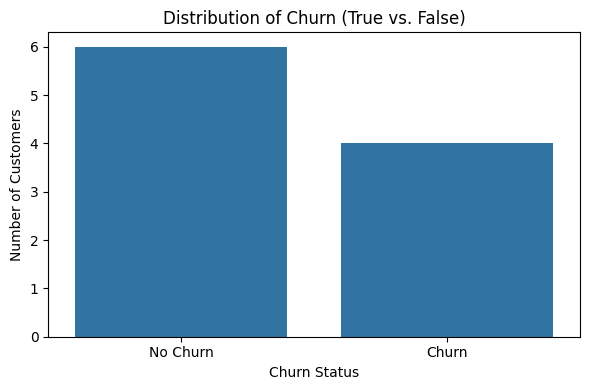

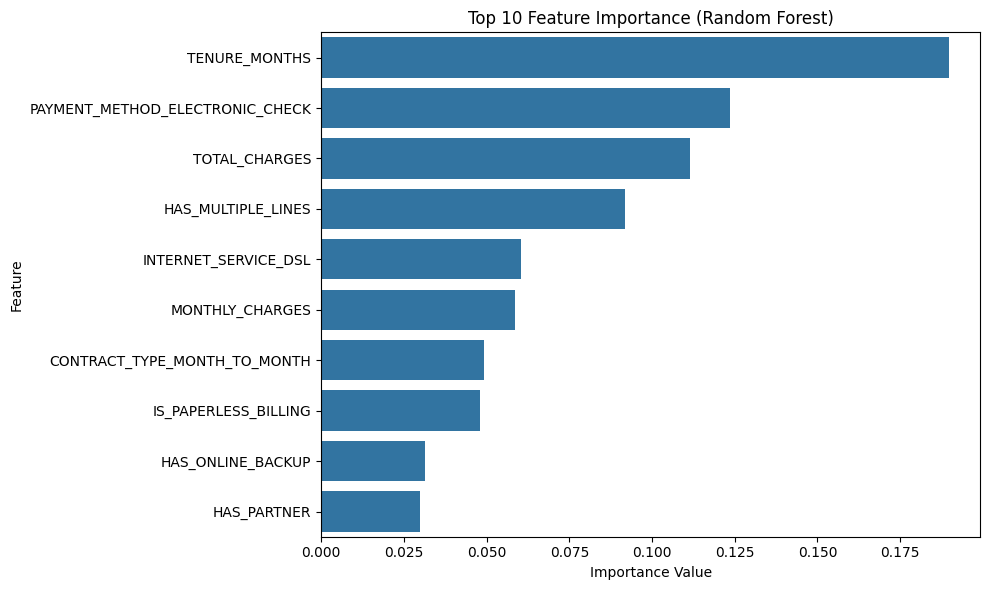

In [ ]:
import snowflake.connector
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier # New model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata # For secure credential retrieval

# --- 1. Securely Retrieve Snowflake Credentials ---
# These variables will get their values from the secure userdata prompts
# Ensure these secrets are set up in Colab's Secrets Manager
SNOWFLAKE_ACCOUNT = userdata.get('SNOWFLAKE_ACCOUNT')
SNOWFLAKE_USER = userdata.get('SNOWFLAKE_USER')
SNOWFLAKE_PASSWORD = userdata.get('SNOWFLAKE_PASSWORD')

# Other details (non-sensitive)
SNOWFLAKE_WAREHOUSE = 'COMPUTE_WH'
SNOWFLAKE_DATABASE = 'CHURN_PREDICTION_DW'
SNOWFLAKE_SCHEMA = 'FEATURES'

# --- 2. Establish Connection to Snowflake & Fetch Data ---
try:
    conn = snowflake.connector.connect(
        user=SNOWFLAKE_USER,
        password=SNOWFLAKE_PASSWORD,
        account=SNOWFLAKE_ACCOUNT,
        warehouse=SNOWFLAKE_WAREHOUSE,
        database=SNOWFLAKE_DATABASE,
        schema=SNOWFLAKE_SCHEMA
    )
    cursor = conn.cursor()
    print("Successfully connected to Snowflake!")

    query = "SELECT * FROM FEATURES.CUSTOMER_CHURN_FEATURES"
    cursor.execute(query)
    df = cursor.fetch_pandas_all()

    print(f"Successfully fetched {len(df)} rows from Snowflake.")
    print("DataFrame head:")
    print(df.head())

except snowflake.connector.errors.ProgrammingError as e:
    print(f"Snowflake Error: {e}")
    # Exit if connection fails
    exit()
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    exit()
finally:
    if 'conn' in locals() and conn:
        cursor.close()
        conn.close()
        print("\nSnowflake connection closed.")

# --- 3. Prepare Data for Machine Learning ---
X = df.drop(['CUSTOMER_ID', 'CHURN_LABEL', 'FEATURE_LOAD_TIMESTAMP'], axis=1)
y = df['CHURN_LABEL']

# Convert boolean columns to integers (True=1, False=0) if not already
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)
    elif X[col].dtype == 'object':
        # Attempt to convert any remaining object types to numeric, coercing errors
        X[col] = pd.to_numeric(X[col], errors='coerce')
        X[col] = X[col].fillna(X[col].mean()) # Simple imputation for NaNs from coercion

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# --- 4. Feature Scaling (StandardScaler) ---
# Apply scaling only to numerical features, after splitting to prevent data leakage
numerical_cols = X.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nFeatures scaled successfully.")
print("Scaled X_train head:")
print(X_train.head())

# --- 5. Train a Logistic Regression Model (with scaled data) ---
print("\n--- Training Logistic Regression Model ---")
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)
lr_y_proba = lr_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Model Evaluation:")
print(classification_report(y_test, lr_y_pred))
print(f"Logistic Regression ROC AUC Score: {roc_auc_score(y_test, lr_y_proba):.4f}")

# --- 6. Train a Random Forest Classifier (New Model) ---
print("\n--- Training Random Forest Classifier ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
rf_y_proba = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Classifier Evaluation:")
print(classification_report(y_test, rf_y_pred))
print(f"Random Forest ROC AUC Score: {roc_auc_score(y_test, rf_y_proba):.4f}")

# --- 7. Hyperparameter Tuning (Example for Random Forest) ---
# Note: With only 10 rows, tuning might not show significant differences,
# but it demonstrates the process.
print("\n--- Hyperparameter Tuning for Random Forest (GridSearchCV) ---")
param_grid = {
    'n_estimators': [50, 100], # Number of trees in the forest
    'max_depth': [None, 5],    # Max depth of the tree
    'min_samples_leaf': [1, 2] # Minimum number of samples required to be at a leaf node
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=2, # Small cv due to small dataset
                           scoring='roc_auc',
                           n_jobs=-1, # Use all available cores
                           verbose=1)

grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best ROC AUC score: {grid_search.best_score_:.4f}")

best_rf_model = grid_search.best_estimator_
best_rf_y_proba = best_rf_model.predict_proba(X_test)[:, 1]
print(f"Best Random Forest Model ROC AUC on Test Set: {roc_auc_score(y_test, best_rf_y_proba):.4f}")


# --- 8. Data Visualization: ROC Curve ---
# Plotting ROC curves for both models
plt.figure(figsize=(8, 6))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_y_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'LR ROC curve (area = {roc_auc_lr:.2f})')

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_y_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'RF ROC curve (area = {roc_auc_rf:.2f})')

# Plotting the random classifier line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# --- 9. Data Visualization: Churn Distribution (from original data) ---
plt.figure(figsize=(6, 4))
sns.countplot(x='CHURN_LABEL', data=df)
plt.title('Distribution of Churn (True vs. False)')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.xticks(ticks=[0, 1], labels=['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

# --- 10. Data Visualization: Feature Importance for Random Forest ---
# Random Forest has its own way of calculating feature importance
if hasattr(best_rf_model, 'feature_importances_'):
    rf_feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.head(10))
    plt.title('Top 10 Feature Importance (Random Forest)')
    plt.xlabel('Importance Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()